In [3]:
import symlib
import pynumdiff
import pynumdiff.optimize
import os
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline


/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_35706/1240625209.py:96: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr, axis=0)
/Users/fengbocheng/PythonEnvs/Astronomy/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


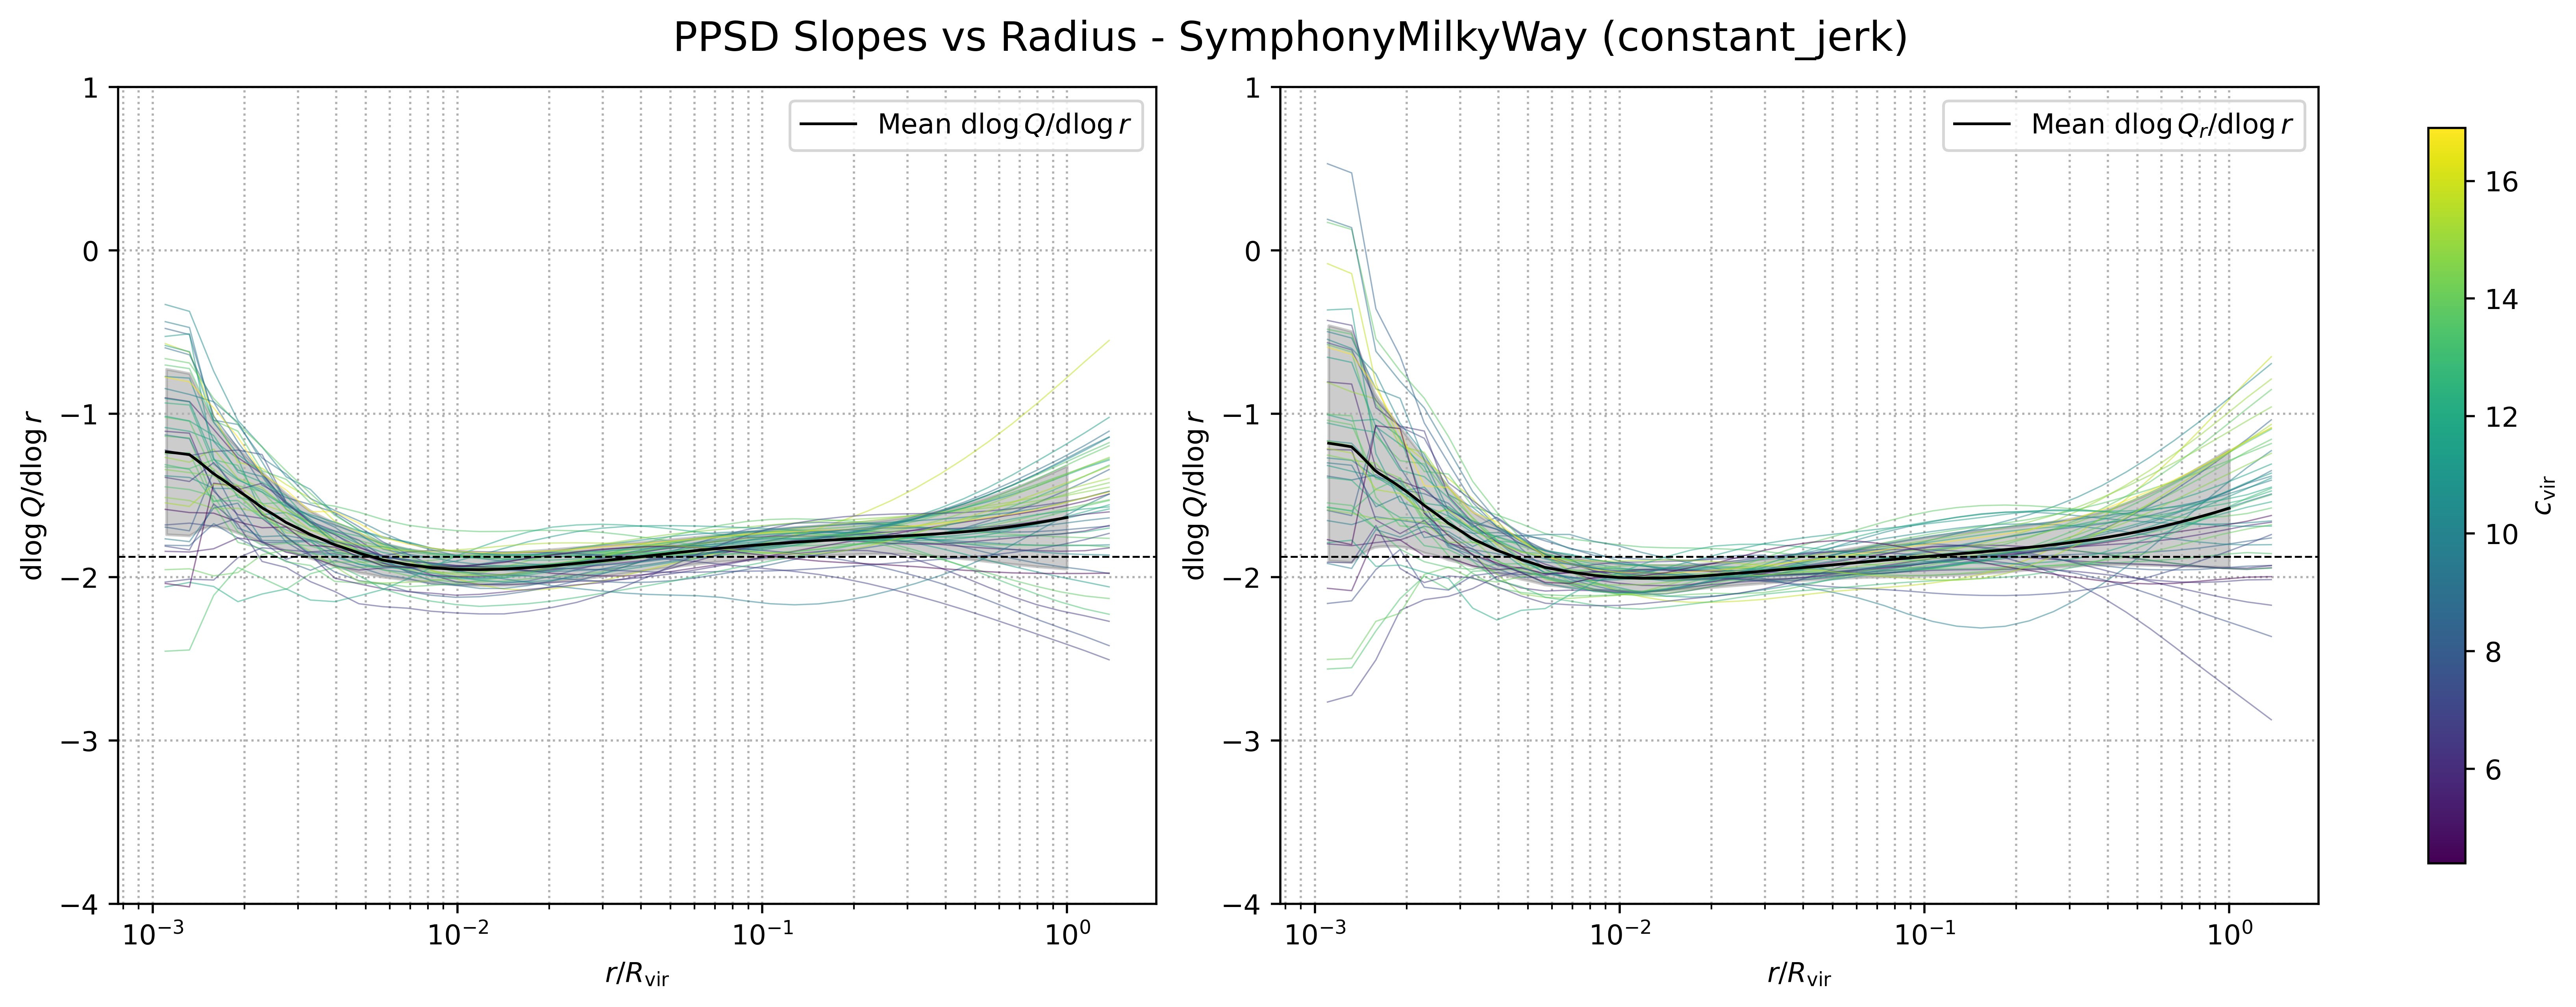

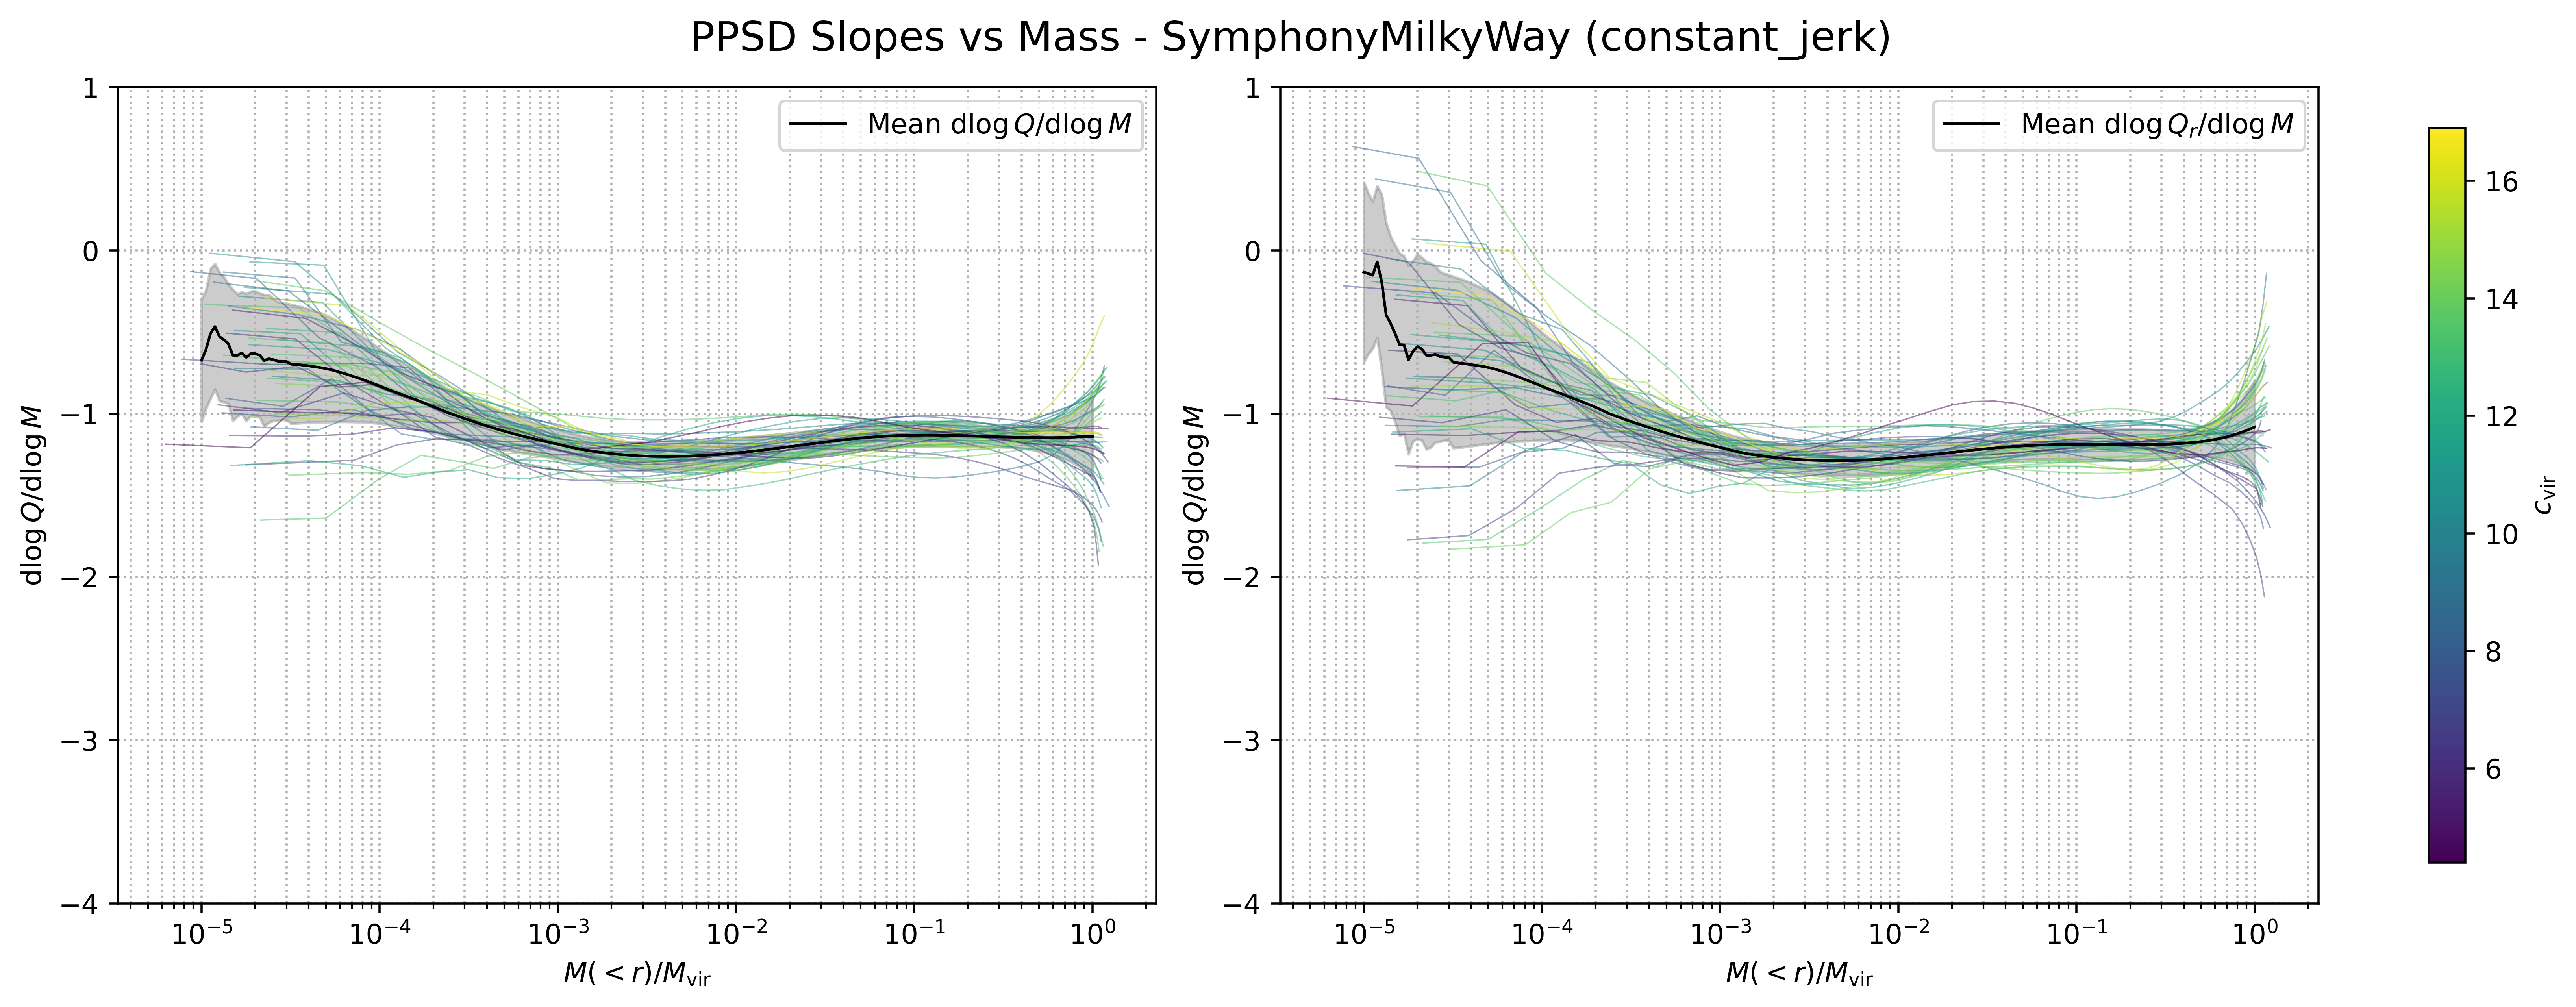

[Saved] slope-only figures colored by concentration (constant_jerk)


In [16]:
def ppsd_slopes_colored_by_c(base_dir, suite_name, method='constant_jerk', tvgamma=None):
    # --- Paths ---
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    # --- Files ---
    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    n_halos = len(density_files)

    # --- Read concentrations ---
    concentrations = []
    for i in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
        try:
            r_data, _ = symlib.read_rockstar(sim_dir)
            cvir_val = r_data[0, -1]["cvir"]
        except Exception as e:
            warnings.warn(f"[Halo {i}] concentration failed: {e}")
            cvir_val = np.nan
        concentrations.append(cvir_val)
    concentrations = np.array(concentrations)

    # --- Color map ---
    cmap = cm.viridis
    norm = colors.Normalize(vmin=np.nanmin(concentrations), vmax=np.nanmax(concentrations))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)

    # --- Plot setup ---
    fig1, axes1 = plt.subplots(1, 2, figsize=(13, 5), dpi=500, constrained_layout=True)
    fig2, axes2 = plt.subplots(1, 2, figsize=(13, 5), dpi=500, constrained_layout=True)
    ax_slope_tot, ax_slope_rad = axes1
    ax_slope_tot_m, ax_slope_rad_m = axes2

    slopes_r_tot, slopes_r_rad = [], []
    slopes_m_tot, slopes_m_rad = [], []

    def fit_and_plot(logx, logQ, ax, storage, color):
        dt = (logx[1:] - logx[:-1]).mean()
        if np.sum(np.isfinite(logx) & np.isfinite(logQ)) < 6: return
        x_valid = logx[np.isfinite(logx) & np.isfinite(logQ)]
        y_valid = logQ[np.isfinite(logx) & np.isfinite(logQ)]
        try:
            for submod in ['linear_model', 'finite_difference', 'smooth_finite_difference', 'total_variation_regularization', 'kalman_smooth']:
                try:
                    optimize_func = getattr(getattr(pynumdiff.optimize, submod), method)
                    diff_func = getattr(getattr(pynumdiff, submod), method)
                    break
                except AttributeError:
                    continue
            kwargs = {'tvgamma': tvgamma} if 'tvgamma' in optimize_func.__code__.co_varnames else {}
            params, _ = optimize_func(y_valid, dt, **kwargs)
            _, dydx = diff_func(y_valid, dt, params)
            x_val = 10**x_valid
            ax.plot(x_val, dydx, color=color, alpha=0.5, lw=0.5)
            storage.append((x_val, dydx))
        except Exception as e:
            warnings.warn(f"{method} failed: {e}")

    for i in range(n_halos):
        df_rho = pd.read_csv(os.path.join(density_dir, density_files[i]))
        df_vel = pd.read_csv(os.path.join(velocity_dir, velocity_files[i]))
        df_mass = pd.read_csv(os.path.join(mass_dir, mass_files[i]))

        r = df_rho["r_scaled"].values
        m = df_mass["m_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)
            Q_rad = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)

        log_r = np.log10(r)
        log_m = np.log10(m)
        log_Q_tot = np.log10(Q_tot)
        log_Q_rad = np.log10(Q_rad)

        color = cmap(norm(concentrations[i])) if np.isfinite(concentrations[i]) else "gray"
        fit_and_plot(log_r, log_Q_tot, ax_slope_tot, slopes_r_tot, color)
        fit_and_plot(log_r, log_Q_rad, ax_slope_rad, slopes_r_rad, color)
        fit_and_plot(log_m, log_Q_tot, ax_slope_tot_m, slopes_m_tot, color)
        fit_and_plot(log_m, log_Q_rad, ax_slope_rad_m, slopes_m_rad, color)

    def plot_mean_shaded(ax, curves, label, x_range):
        x_common = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 200)
        interp = [np.interp(x_common, x, y, left=np.nan, right=np.nan)
                  for x, y in curves if np.all(np.isfinite(x)) and np.all(np.isfinite(y))]
        if not interp: return
        arr = np.array(interp)
        mean = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        ax.plot(x_common, mean, 'k-', lw=1, label=label)
        ax.fill_between(x_common, mean - std, mean + std, color='gray', alpha=0.4)
        ax.legend()

    plot_mean_shaded(ax_slope_tot, slopes_r_tot, r"Mean $\mathrm{d}\log Q/\mathrm{d}\log r$", (1e-3, 1))
    plot_mean_shaded(ax_slope_rad, slopes_r_rad, r"Mean $\mathrm{d}\log Q_r/\mathrm{d}\log r$", (1e-3, 1))
    plot_mean_shaded(ax_slope_tot_m, slopes_m_tot, r"Mean $\mathrm{d}\log Q/\mathrm{d}\log M$", (1e-5, 1))
    plot_mean_shaded(ax_slope_rad_m, slopes_m_rad, r"Mean $\mathrm{d}\log Q_r/\mathrm{d}\log M$", (1e-5, 1))

    for ax in [ax_slope_tot, ax_slope_rad]:
        ax.set_xlabel(r"$r / R_{\mathrm{vir}}$")
        ax.set_ylabel(r"$\mathrm{d}\log Q / \mathrm{d}\log r$")
        ax.set_xscale("log")
        ax.set_ylim(-4, 1)
        ax.axhline(-1.875, color='k', ls='--', lw=0.7)
        ax.grid(True, which="both", linestyle=":")

    for ax in [ax_slope_tot_m, ax_slope_rad_m]:
        ax.set_xlabel(r"$M(<r) / M_{\mathrm{vir}}$")
        ax.set_ylabel(r"$\mathrm{d}\log Q / \mathrm{d}\log M$")
        ax.set_xscale("log")
        ax.set_ylim(-4, 1)
        ax.grid(True, which="both", linestyle=":")

    fig1.suptitle(f"PPSD Slopes vs Radius - {suite_name} ({method})", fontsize=15)
    fig1.colorbar(sm, ax=axes1.ravel().tolist(), shrink=0.9).set_label(r"$c_{\mathrm{vir}}$")
    fig1.savefig(os.path.join(output_dir, f"PPSD_slopes_r_only_c_{method}.png"))

    fig2.suptitle(f"PPSD Slopes vs Mass - {suite_name} ({method})", fontsize=15)
    fig2.colorbar(sm, ax=axes2.ravel().tolist(), shrink=0.9).set_label(r"$c_{\mathrm{vir}}$")
    fig2.savefig(os.path.join(output_dir, f"PPSD_slopes_m_only_c_{method}.png"))

    plt.show()
    plt.close(fig1)
    plt.close(fig2)

    print(f"[Saved] slope-only figures colored by concentration ({method})")

ppsd_slopes_colored_by_c(
    "/Volumes/Atlas/Symphony",
    "SymphonyMilkyWay",
    method='constant_jerk',
    tvgamma=None
)

In [ ]:
def run_all_pynumdiff_methods(base_dir, suite_name):
    methods = [
        "constant_jerk"
    ]
    for method in methods:
        print(f"\n--- Running {method} ---")
        ppsd_slopes_colored_by_c(base_dir, suite_name, method=method)

run_all_pynumdiff_methods("/Volumes/Atlas/Symphony", "SymphonyMilkyWay")

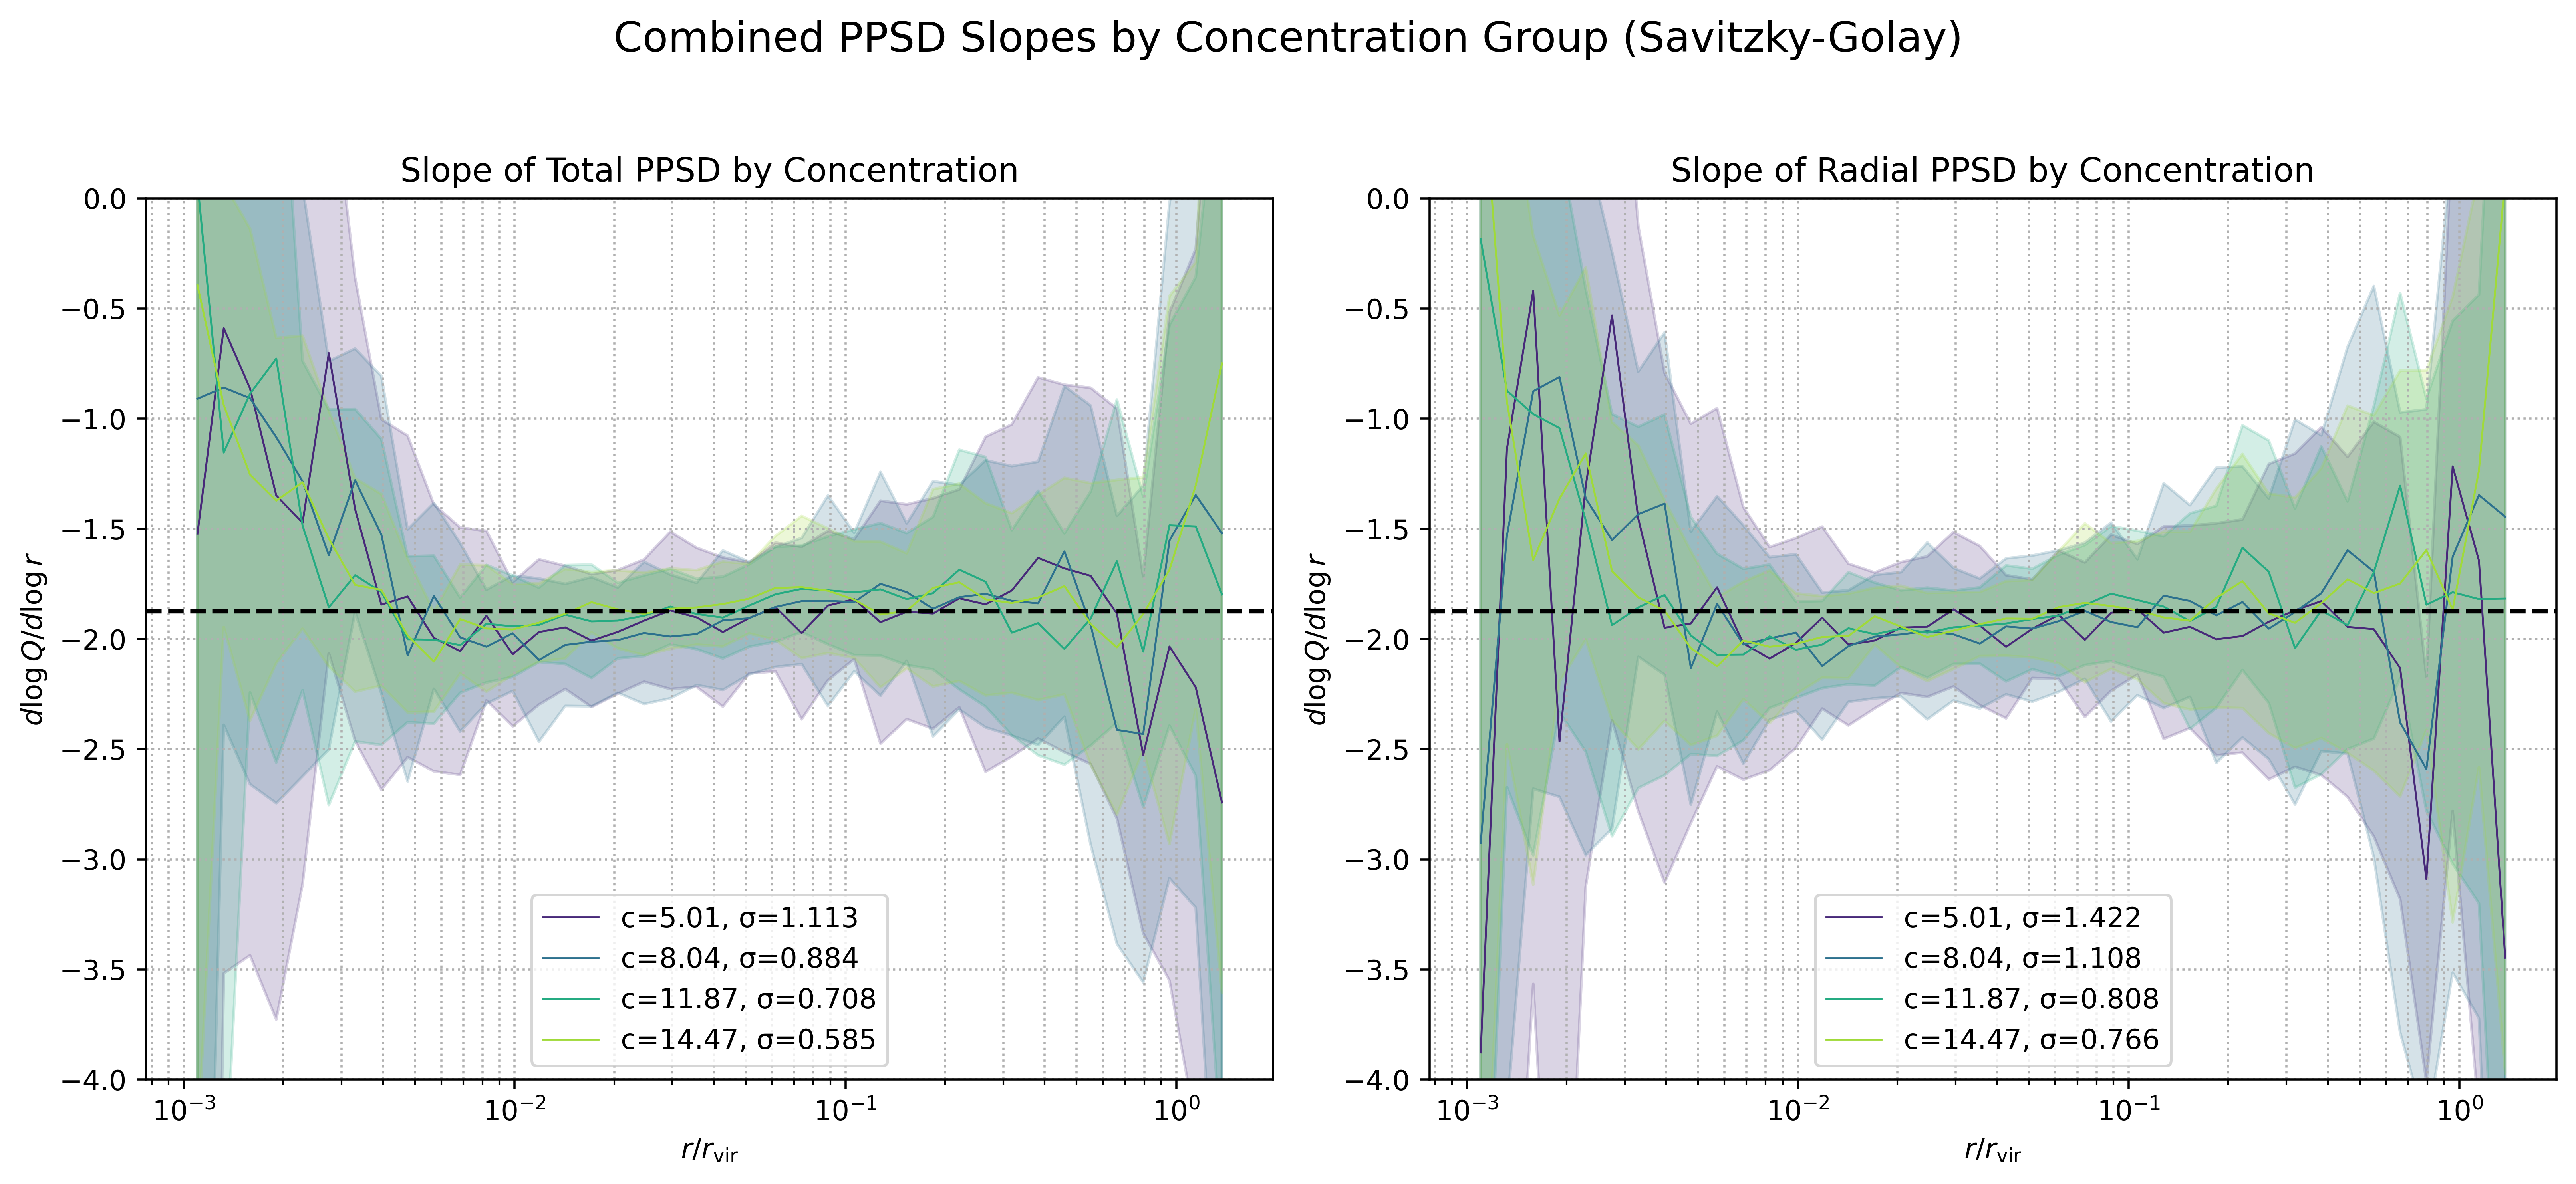

[Saved] Combined PPSD slope figure


In [ ]:

def plot_combined_slopes_by_c(base_dir, suite_names,window_length=5, polyorder=3):
    """
    Combine multiple suites' halos, group by concentration (c_vir) percentiles,
    compute Savitzky-Golay smoothed slopes of total and radial PPSD,
    and plot mean slopes with std shaded regions per concentration bin.
    Legend shows mean concentration and slope std per group.
    """

    all_concs = []
    all_slope_tot = []
    all_slope_rad = []
    all_r = []

    # Loop over each suite
    for suite_name in suite_names:
        density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")

        density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
        velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
        n_halos = len(density_files)

        # Loop over each halo
        for i in range(n_halos):
            sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
            try:
                r_data, hist = symlib.read_rockstar(sim_dir)
                host = r_data[0, -1]
                cvir = host['cvir']
            except Exception:
                continue  # Skip if data unavailable

            # Read density and velocity profiles
            df_rho = pd.read_csv(os.path.join(density_dir, density_files[i]))
            df_vel = pd.read_csv(os.path.join(velocity_dir, velocity_files[i]))

            r = df_rho["r_scaled"].values
            rho = df_rho["rho_scaled"].values
            sigma_tot = df_vel["sigma_total_scaled"].values
            sigma_rad = df_vel["sigma_rad_scaled"].values

            # Compute pseudo phase-space density Q = rho / sigma^3
            with np.errstate(divide="ignore", invalid="ignore"):
                Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)
                Q_rad = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)

            log_Q_tot = np.log10(Q_tot)
            log_Q_rad = np.log10(Q_rad)
            log_r = np.log10(r)

            valid_tot = np.isfinite(log_Q_tot)
            valid_rad = np.isfinite(log_Q_rad)

            # Apply Savitzky-Golay filter to smooth and calculate slope (derivative)
            if np.sum(valid_tot) >= window_length and np.sum(valid_rad) >= window_length:
                delta_log_r = np.diff(log_r)[0]

                slope_tot = savgol_filter(log_Q_tot[valid_tot], window_length, polyorder,
                                          deriv=1, delta=delta_log_r, mode='interp')
                slope_rad = savgol_filter(log_Q_rad[valid_rad], window_length, polyorder,
                                          deriv=1, delta=delta_log_r, mode='interp')

                slope_full_tot = np.full_like(log_r, np.nan)
                slope_full_rad = np.full_like(log_r, np.nan)
                slope_full_tot[valid_tot] = slope_tot
                slope_full_rad[valid_rad] = slope_rad

                all_concs.append(cvir)
                all_slope_tot.append(slope_full_tot)
                all_slope_rad.append(slope_full_rad)
                all_r.append(r)

    all_concs = np.array(all_concs)
    all_slope_tot = np.array(all_slope_tot)
    all_slope_rad = np.array(all_slope_rad)
    all_r = np.array(all_r)

    # Define concentration bins by percentiles
    c_bins = np.percentile(all_concs, [0, 25, 50, 75, 100])
    cmap = cm.viridis
    norm = plt.Normalize(vmin=np.nanmin(all_concs), vmax=np.nanmax(all_concs))
    colors = [cmap(norm(np.mean(c_bins[i:i+2]))) for i in range(4)]

    fig, axes = plt.subplots(1, 2, figsize=(13, 6), dpi=500, sharex=True)
    ax_tot, ax_rad = axes

    # Loop over bins to plot mean slopes with shaded std
    for i in range(4):
        in_bin = (all_concs >= c_bins[i]) & (all_concs < c_bins[i+1])
        group_slope_tot = all_slope_tot[in_bin]
        group_slope_rad = all_slope_rad[in_bin]
        r_bin = all_r[in_bin]

        if len(r_bin) == 0:
            continue

        r_ref = r_bin[0]  # Assume common radius grid
        slope_tot_mean = np.nanmean(group_slope_tot, axis=0)
        slope_tot_std = np.nanstd(group_slope_tot, axis=0)
        slope_rad_mean = np.nanmean(group_slope_rad, axis=0)
        slope_rad_std = np.nanstd(group_slope_rad, axis=0)

        mean_c = np.nanmean(all_concs[in_bin])
        mean_sigma_tot = np.nanmean(slope_tot_std)
        mean_sigma_rad = np.nanmean(slope_rad_std)

        label_tot = f"c={mean_c:.2f}, σ={mean_sigma_tot:.3f}"
        label_rad = f"c={mean_c:.2f}, σ={mean_sigma_rad:.3f}"

        ax_tot.plot(r_ref, slope_tot_mean, lw=0.7, label=label_tot, color=colors[i])
        ax_tot.fill_between(r_ref, slope_tot_mean - slope_tot_std,
                            slope_tot_mean + slope_tot_std,
                            alpha=0.2, color=colors[i])

        ax_rad.plot(r_ref, slope_rad_mean, lw=0.7, label=label_rad, color=colors[i])
        ax_rad.fill_between(r_ref, slope_rad_mean - slope_rad_std,
                            slope_rad_mean + slope_rad_std,
                            alpha=0.2, color=colors[i])

    # Format axes
    for ax in axes:
        ax.axhline(-1.875, color='k', linestyle='--')
        ax.set_xscale("log")
        ax.set_ylim(-4, 0)
        ax.set_xlabel(r"$r / r_{\rm vir}$")
        ax.set_ylabel(r"$d\log Q / d\log r$")
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    ax_tot.set_title("Slope of Total PPSD by Concentration")
    ax_rad.set_title("Slope of Radial PPSD by Concentration")

    fig.suptitle("Combined PPSD Slopes by Concentration Group (Savitzky-Golay)", fontsize=15)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    output_dir = os.path.join(base_dir, "output", "combined", "figures")
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, "PPSD_slopes_by_concentration.png"))
    plt.show()
    print("[Saved] Combined PPSD slope figure")

# Example usage:
plot_combined_slopes_by_c(
    "/Volumes/Atlas/Symphony",
    ["SymphonyMilkyWay", "SymphonyLMC", "SymphonyLCluster"]
)

In [ ]:
import pynumdiff.kalman_smooth
import pynumdiff.optimize.kalman_smooth

# --- Compute slope of log_y with respect to log_x using Kalman smooth method ---
def compute_kalman_slope(log_x, log_y):
    valid = np.isfinite(log_x) & np.isfinite(log_y)
    if np.sum(valid) < 5:
        return None
    dt = np.mean(np.diff(log_x[valid]))
    try:
        params, _ = pynumdiff.optimize.kalman_smooth.constant_jerk(log_y[valid], dt)
        _, slope = pynumdiff.kalman_smooth.constant_jerk(log_y[valid], dt, params)
    except Exception:
        return None
    slope_full = np.full_like(log_x, np.nan)
    slope_full[valid] = slope
    return slope_full

# --- Main function ---
def plot_concentration_split_combined_suites(base_dir, suite_names):
    # Lists to store combined data
    low_r_list, high_r_list = [], []
    low_m_list, high_m_list = [], []
    low_slope_r_Qr_list, high_slope_r_Qr_list = [], []
    low_slope_r_Qtot_list, high_slope_r_Qtot_list = [], []
    low_slope_m_Qr_list, high_slope_m_Qr_list = [], []
    low_slope_m_Qtot_list, high_slope_m_Qtot_list = [], []
    low_cvir_list, high_cvir_list = [], []

    # Loop over simulation suites
    for suite in suite_names:
        density_dir = os.path.join(base_dir, "output", suite, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        mass_dir = os.path.join(base_dir, "output", suite, "mass_profiles")

        files = zip(
            sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")]),
            sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")]),
            sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
        )

        # Get all concentrations for this suite
        cvirs_suite = []
        for i, (f_rho, f_vel, f_mass) in enumerate(files):
            try:
                sim_dir = symlib.get_host_directory(base_dir, suite, i)
                r_data, _ = symlib.read_rockstar(sim_dir)
                cvir = r_data[0, -1]["cvir"]
                cvirs_suite.append(cvir)
            except:
                cvirs_suite.append(np.nan)
        cvirs_suite = np.array(cvirs_suite)
        suite_median_c = np.nanmedian(cvirs_suite)

        # Loop again and assign halos into low/high-c groups
        for i, (f_rho, f_vel, f_mass) in enumerate(files):
            try:
                cvir = cvirs_suite[i]
                if not np.isfinite(cvir):
                    continue

                sim_dir = symlib.get_host_directory(base_dir, suite, i)
                df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
                df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))
                df_mass = pd.read_csv(os.path.join(mass_dir, f_mass))

                r = df_rho["r_scaled"].values
                rho = df_rho["rho_scaled"].values
                sigma_rad = df_vel["sigma_rad_scaled"].values
                sigma_tot = df_vel["sigma_total_scaled"].values
                mass = df_mass["m_scaled"].values

                with np.errstate(divide="ignore", invalid="ignore"):
                    Qr = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)
                    Qtot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)

                log_r = np.log10(r)
                log_m = np.log10(mass)
                log_Qr = np.log10(Qr)
                log_Qtot = np.log10(Qtot)

                slope_r_Qr = compute_kalman_slope(log_r, log_Qr)
                slope_r_Qtot = compute_kalman_slope(log_r, log_Qtot)
                slope_m_Qr = compute_kalman_slope(log_m, log_Qr)
                slope_m_Qtot = compute_kalman_slope(log_m, log_Qtot)

                if slope_r_Qr is None or slope_r_Qtot is None:
                    continue

                if cvir <= suite_median_c:
                    low_r_list.append(r)
                    low_m_list.append(mass)
                    low_slope_r_Qr_list.append(slope_r_Qr)
                    low_slope_r_Qtot_list.append(slope_r_Qtot)
                    low_slope_m_Qr_list.append(slope_m_Qr)
                    low_slope_m_Qtot_list.append(slope_m_Qtot)
                    low_cvir_list.append(cvir)
                else:
                    high_r_list.append(r)
                    high_m_list.append(mass)
                    high_slope_r_Qr_list.append(slope_r_Qr)
                    high_slope_r_Qtot_list.append(slope_r_Qtot)
                    high_slope_m_Qr_list.append(slope_m_Qr)
                    high_slope_m_Qtot_list.append(slope_m_Qtot)
                    high_cvir_list.append(cvir)
            except:
                continue
        print(f"[{suite}] total halos: {len(cvirs_suite)}, valid halos: {np.sum(np.isfinite(cvirs_suite))}")
        print(f"Low c halos: {len(low_cvir_list)}, High c halos: {len(high_cvir_list)}")
    # --- Plotting function with legend info ---
    def mean_std_plot(ax, x_list, y_list, cvirs, color, label_base):
        if len(x_list) == 0 or len(y_list) == 0:
            return  # Skip empty groups
        
        x_ref = x_list[0]
        y_stack = np.stack(y_list)
        y_mean = np.nanmean(y_stack, axis=0)
        y_std = np.nanstd(y_stack, axis=0)

        N = len(cvirs)
        c_mean = np.nanmean(cvirs)
        c_std = np.nanstd(cvirs)

        label = f"{label_base} (N={N}, ⟨c⟩={c_mean:.2f}, σ={c_std:.2f})"
        ax.plot(x_ref, y_mean, color=color, lw=1.2, label=label)
        ax.fill_between(x_ref, y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)
        
    # --- Create plots ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=600)
    ax1, ax2, ax3, ax4 = axes.flatten()

    mean_std_plot(ax1, low_r_list, low_slope_r_Qr_list, low_cvir_list, "steelblue", "Low c")
    mean_std_plot(ax1, high_r_list, high_slope_r_Qr_list, high_cvir_list, "firebrick", "High c")
    ax1.set_title(r"$Q_r$ vs $r$")

    mean_std_plot(ax2, low_r_list, low_slope_r_Qtot_list, low_cvir_list, "steelblue", "Low c")
    mean_std_plot(ax2, high_r_list, high_slope_r_Qtot_list, high_cvir_list, "firebrick", "High c")
    ax2.set_title(r"$Q_{\rm tot}$ vs $r$")

    mean_std_plot(ax3, low_m_list, low_slope_m_Qr_list, low_cvir_list, "steelblue", "Low c")
    mean_std_plot(ax3, high_m_list, high_slope_m_Qr_list, high_cvir_list, "firebrick", "High c")
    ax3.set_title(r"$Q_r$ vs $M$")

    mean_std_plot(ax4, low_m_list, low_slope_m_Qtot_list, low_cvir_list, "steelblue", "Low c")
    mean_std_plot(ax4, high_m_list, high_slope_m_Qtot_list, high_cvir_list, "firebrick", "High c")
    ax4.set_title(r"$Q_{\rm tot}$ vs $M$")

    for ax in axes.flatten():
        ax.axhline(-1.875, ls="--", color="k")
        ax.set_xscale("log")
        ax.set_ylim(-3, 0)
        ax.set_ylabel("Slope")
        ax.set_xlabel("Scaled r or M")
        ax.legend()
        ax.grid(True, which="both", linestyle=":")

    fig.suptitle("PPSD Slopes by Concentration (Suite-internal Split, Combined Suites)", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    outdir = os.path.join(base_dir, "output", "combined", "figures")
    os.makedirs(outdir, exist_ok=True)
    fig.savefig(os.path.join(outdir, "PPSD_slopes_by_concentration_suite_split.png"))
    plt.show()

# --- Example usage ---
base_dir = "/Volumes/Atlas/Symphony"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyLCluster"]
plot_concentration_split_combined_suites(base_dir, suite_names)